# Visualize interactively AIM images using the k3d library

This notebook is intended to guide you through the process of visualizing and apply basic image processing operations to the AIM images loaded via the ``vtkbone`` library.
As the ``vtkbone`` library is meant for IO operations, a visualization package is outside of the scope of the library. However, we provide informations on the usage of a compatible library, ``k3d``, which integrate seamlessly with the vtk image data structure.

## Step 1: Import necessary packages

In [39]:
import functools
from pathlib import Path

import k3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import SimpleITK as sitk
import vtk

import vtkbone
from python_helpers.vtk_util import vtkImageData_to_numpy, numpy_to_vtkImageData

### Get the k3d package if not already installed

In [40]:
%pip install k3d

Note: you may need to restart the kernel to use updated packages.


## Step 2: Read the image using ``vtkbone``

In [41]:
# Give the path to your AIM file
impath = Path('./data/TRAB_1240.AIM')

We first read the 3D image from an AIM file using the ``vtkboneAIMReader``. The read_image function is decorated with ``@print_image_info`` to print the image's properties (spacing, origin, dimensions, byte format) upon reading.

In [42]:
# decorator that print informations such as spacing, origin, dimensions, byte format
def print_image_info(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        image = func(*args, **kwargs)
        spacing = image.GetSpacing()
        origin = image.GetOrigin()
        dimensions = image.GetDimensions()
        byte_format = image.GetScalarTypeAsString()

        print("Image Informations:")
        print(f"Spacing: {np.round(spacing, 3)}")
        print(f"Origin: {np.round(origin, 3)}")
        print(f"Dimensions: {dimensions}")
        print(f"Byte Format: {byte_format}")

        return image
    
    return wrapper

We then define and apply the function ``read_image()`` to read the image from the AIM file. Please refer to notebook [**01_reading_in_aims**](01_reading_in_aims.ipynb)
 for more details on the ``vtkboneAIMReader``.

In [43]:
@print_image_info
def read_image(aim_path: Path):
    """
    Read a 3D image from a file using the vtkboneAIMReader to read a 3D image from a file in the AIM format. 

    Parameters:
    aim_path (Path): The path to the AIM file to read.

    Returns:
    vtkImageData: The 3D image read from the file.
    """
    print(f'Reading file: {aim_path}')
    reader = vtkbone.vtkboneAIMReader()
    reader.DataOnCellsOff()
    reader.SetFileName(str(aim_path.resolve()))
    reader.Update()
    return reader.GetOutput()

# execute the function
image = read_image(impath)

Reading file: data/TRAB_1240.AIM
Image Informations:
Spacing: [0.061 0.061 0.061]
Origin: [60.73  45.434 12.716]
Dimensions: (108, 108, 126)
Byte Format: short


## Step 3: Visualize the image using ``k3d``
### Step 3.1: Convert the image to a numpy array

In this conversion step, we return a numpy array containing the informations of the image. VTK images are indexed in the order [x, y, z], while numpy array are indexed in the opposite order [z, y, x]. We therefore need to reverse the order of the dimensions of the image.

In [44]:
# Use python_helpers.vtk_util to convert vtkImageData to numpy array
imnp = vtkImageData_to_numpy(image)
# Transpose and flip the array to have the same indexing and direction as the original AIM image
imnp = np.transpose(imnp, (2, 1, 0))
imnp = np.flip(imnp, axis=2)
# Enforce float16 type (best for k3d)
imnp = imnp.astype(np.float16)

### Step 3.2: Get information about the image for visualization

We then want to include some image information in the visualization. We therefore get the spacing, origin, and dimensions of the image to create a transformation matrix that will be used to correctly position the image in the visualization.

In [45]:
# Extract spacing, origin, and dimensions from a vtkImageData object. These are important properties that describe the resolution, position, and physical size of the image.
spacing = image.GetSpacing()
origin = image.GetOrigin()
dimensions = image.GetDimensions()

Generate a transformation matrix for a 3D image. This function takes the spacing, origin, and dimensions of a 3D image and generates a transformation matrix.  This matrix can be used to transform the voxel coordinates of the image to world coordinates.

In [46]:
transform_matrix = np.array([
    [spacing[0] * dimensions[0], 0, 0, origin[0]],
    [0, spacing[1] * dimensions[1], 0, origin[1]],
    [0, 0, spacing[2] * dimensions[2], origin[2]],
    [0, 0, 0, 1]
])

In order to decide which range of intensities we want to visualize, plotting the histogram of the image is a good way to get an idea of the distribution of the intensities.

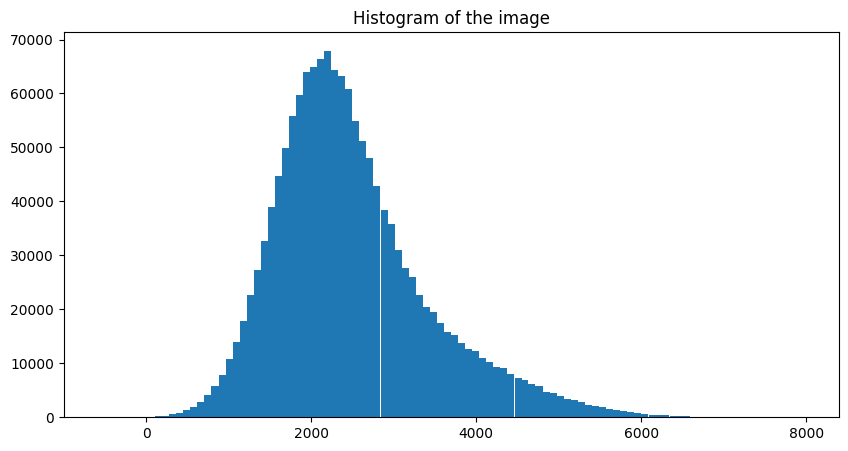

In [47]:
plt.figure(figsize=(10, 5))
plt.hist(imnp.flatten(), bins=100)
plt.title('Histogram of the image')
plt.show()

For instance, the code snippet below takes into account different cases for the type of images that we read. If the image is a native greyscale, then a good vmin to use as a starting point would be ``vmin = 3000``. If the image is a greyscale with a range of intensities, then we can use the minimum intensity as the starting point. If the image is a mask, the minimum intensity would be ``0`` and the maximum intensity would be ``127``.

In [48]:
# We take the numpy array representing the image and calculates the minimum and maximum intensity values for that image.
# These values can be used for setting the intensity range when visualizing the image.
# We can also overwrite these or modify them directly in the k3d controls later on.

# Calculate the minimum and maximum intensity values for a numpy array.
intensity_min = np.min(imnp)
intensity_max = np.max(imnp)

if intensity_max > 1:
    vmin = 0.01
    if intensity_max > 127:
        vmin = 3000
vmax = intensity_max

### Step 3.3: Create the visualization

In [49]:
transform_s = k3d.transform(custom_matrix=transform_matrix)

# Instantiate the volume plot using k3d-jupyter
plt_volume = k3d.volume(imnp,
                        transform=transform_s,
                        color_map=k3d.colormaps.basic_color_maps.Binary,
                        samples=256,
                        alpha_coef=150,
                        color_range=[vmin, vmax])
plot = k3d.plot()
plot += plt_volume
# Display the plot inline
plot.display()

Output()

# Visualize AIM image slices using the matplotlib library

Matplotlib is a powerful library for creating static, animated, and interactive visualizations in Python. Here's how you can use it to visualize slices of an AIM image. Assume you have a 3D numpy array image representing your AIM image. You can get slices of this image like so:

In [50]:
slice1 = imnp[50, :, :]  # Slice at index 50 along the x-axis
slice2 = imnp[:, 100, :]  # Slice at index 50 along the y-axis
slice3 = imnp[:, :, 100]  # Slice at index 50 along the z-axis

Now, you can use matplotlib to visualize these slices in 3 rows:

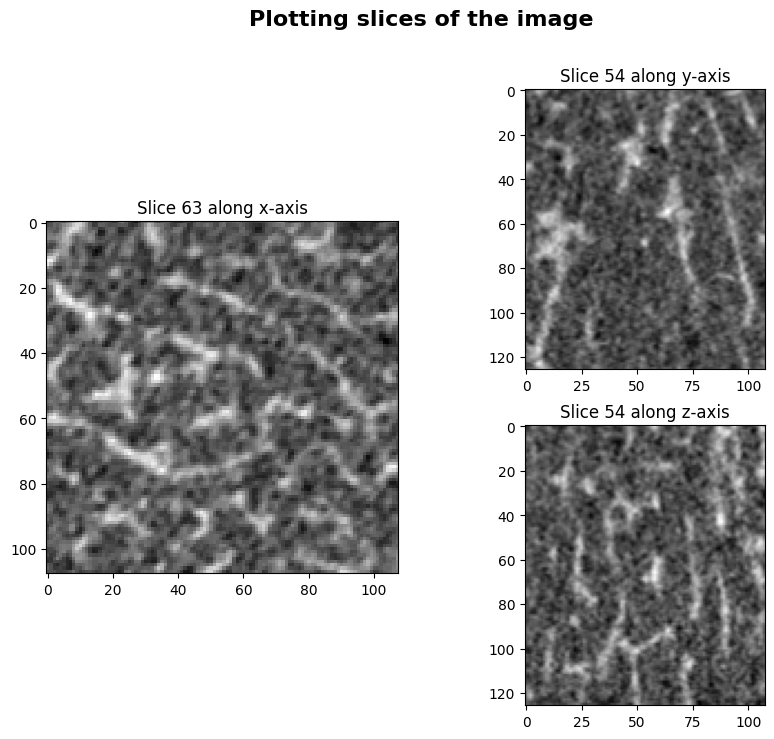

In [57]:
def imshow_2d(im_sitk: sitk.Image, idx_x: int = 50, idx_y: int = 100, idx_z: int = 100):
    def sitk_to_numpy(image: sitk.Image, preserve_indexing: bool = False):
        if preserve_indexing:
            imnp = sitk.GetArrayFromImage(image)
            return imnp
        else:
            return sitk.GetArrayFromImage(image)

    imnp = sitk_to_numpy(im_sitk, preserve_indexing=True)
    slice1 = imnp[idx_x, :, :]  # Slice at index 50 along the x-axis
    slice3 = imnp[:, :, idx_z]  # Slice at index 50 along the z-axis
    slice2 = imnp[:, idx_y, :]  # Slice at index 50 along the y-axis
    # Create a 2x2 grid
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(10, 8))
    ax0 = fig.add_subplot(gs[:, 0])  # This subplot spans two rows and one column
    ax1 = fig.add_subplot(gs[0, 1])  # This subplot is in the first row and second column
    ax2 = fig.add_subplot(gs[1, 1])  # This subplot is in the second row and second column

    ax0.imshow(slice1, cmap='gray')
    ax1.imshow(slice2, cmap='gray')
    ax2.imshow(slice3, cmap='gray')

    ax0.set_title(f'Slice {idx_x} along x-axis')
    ax1.set_title(f'Slice {idx_y} along y-axis')
    ax2.set_title(f'Slice {idx_z} along z-axis')

    plt.suptitle(f'Plotting slices of the image', weight='bold', fontsize=16)
    plt.show()
    return None

half_x = int(imnp.shape[0] / 2)
half_y = int(imnp.shape[1] / 2)
half_z = int(imnp.shape[2] / 2)

# convert vtk to simpleitk image
imsitk = sitk.GetImageFromArray(imnp.astype(np.float32))
imshow_2d(imsitk, idx_x=half_x, idx_y=half_y, idx_z=half_z)

and so on...